# CS6120 - Natural Language Processing - Summer 2024
## Instructor: Amir Tahmasebi

# Assignment 4

## Text Classification Using TF-IDF and Logistic Regression

# Objective:
In this section, you will develop a text classification model using TF-IDF (Term Frequency-Inverse Document Frequency) for feature extraction and a Logistic Regression classifier for categorization. The goal is to understand how to process textual data, transform it into a suitable format for machine learning algorithms, and apply a classification model to predict the category of unseen documents.


In [2]:
# Import all necessary libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_files

import numpy as np
import pandas as pd
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
pip install --upgrade scikit-learn

In [3]:
# load the data and learn insights about it
newsgroups = fetch_20newsgroups(subset='all')

print("Number of articles: " + str(len(newsgroups.data)))
print("Number of diffrent categories: " + str(len(newsgroups.target_names)))


Number of articles: 18846
Number of diffrent categories: 20


Each document is a text written in English in a form of an email with a lot of punctuations. You should always do some pre-processing but here we’ll just concentrate on the model.

In [4]:
# print sample data
print("\n".join(newsgroups.data[1121].split("\n")[:]))


From: et@teal.csn.org (Eric H. Taylor)
Subject: Re: Gravity waves, was: Predicting gravity wave quantization & Cosmic Noise
Summary: Dong ....  Dong ....  Do I hear the death-knell of relativity?
Keywords: space, curvature, nothing, tesla
Nntp-Posting-Host: teal.csn.org
Organization: 4-L Laboratories
Distribution: World
Expires: Wed, 28 Apr 1993 06:00:00 GMT
Lines: 30

In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:
>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:
>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:
>>> "Existence" is undefined unless it is synonymous with "observable" in
>>> physics.
>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of
>> string theory?
>
>     I agree.  You can add "dark matter" and quarks and a lot of other
>unobservable, purely theoretical constructs in physics to that list,
>including the omni-present "black holes."
>
>     Will Bruce argue that their existence can be inferre

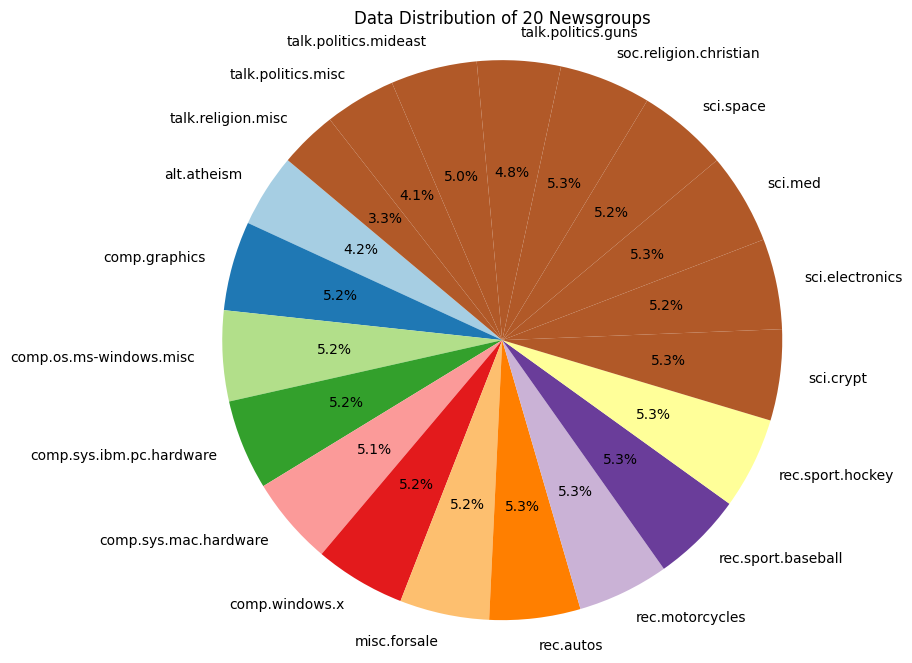

In [5]:
# Count the number of documents in each category
category_counts = dict(zip(newsgroups.target_names, [0] * len(newsgroups.target_names)))
for target in newsgroups.target:
    category_counts[newsgroups.target_names[target]] += 1

# Data to plot
labels = list(category_counts.keys())
sizes = list(category_counts.values())
colors = plt.cm.Paired(range(len(labels)))

# Plot
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution of 20 Newsgroups')
plt.show()

## Load Training Set from NewsGroups Dataset

In [6]:
#Loading the training data.
mydata_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Training data size:', len(mydata_train['data']))

Training data size: 11314


## Load Test Set from NewsGroup Dataset

In [7]:
#Loading the test data.
mydata_test = fetch_20newsgroups(subset='test', shuffle=True, remove = ('headers', 'footers', 'quotes'))
print('Test data size:', len(mydata_test['data']))

Test data size: 7532


## Data Preparation:
You need to perform preparation steps such as Tokenization, Convert everything to lowercase, Removing stopwords, Stemming, Lemmatizing, and converting text data to a vector representation.

It is easier if you store your data in dataframe but not necessarily needed.

In [8]:
# you can store the data in dataframe for easier processing
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [12]:
# Preparing test data accordingly
mydata_test_df = pd.DataFrame({'data': mydata_test.data, 'target': mydata_test.target})
mydata_test_df.head()

,data,target
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [13]:
# <<<<    Add code  here    >>>>
# Suggestions: Text preprocessing steps - remove numbers, captial letters and punctuation
# apply preprocessing to both training and test sets
# lets assume you store preprocessed data in:
# mydata_train_df['preproc']
# mydata_test_df['preproc']

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing to both training and test sets
mydata_train_df['preproc'] = mydata_train_df['data'].apply(preprocess_text)
mydata_test_df['preproc'] = mydata_test_df['data'].apply(preprocess_text)

# Display the preprocessed data
print("Preprocessed Training DataFrame head:\n", mydata_train_df.head())
print("Preprocessed Test DataFrame head:\n", mydata_test_df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessed Training DataFrame head:
                                                 data  target  \
0  I was wondering if anyone out there could enli...       7   
1  A fair number of brave souls who upgraded thei...       4   
2  well folks, my mac plus finally gave up the gh...       4   
3  \nDo you have Weitek's address/phone number?  ...       1   
4  From article <C5owCB.n3p@world.std.com>, by to...      14   

                                             preproc  
0  wondering anyone could enlighten car saw day d...  
1  fair number brave soul upgraded si clock oscil...  
2  well folk mac plus finally gave ghost weekend ...  
3  weiteks addressphone number id like get inform...  
4  article cowcbnpworldstdcom tombakerworldstdcom...  
Preprocessed Test DataFrame head:
                                                 data  target  \
0  I am a little confused on all of the models of...       7   
1  I'm not familiar at all with the format of the...       5   
2                  

## TF-IDF Vectorization
Implement TF-IDF here. You can use sklearn.

In [14]:
# <<<<    Add code  here    >>>>
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(mydata_train_df['preproc'])
y_train = mydata_train_df['target']

# Transform the test data
X_test_tfidf = vectorizer.transform(mydata_test_df['preproc'])
y_test = mydata_test_df['target']

# Display the shape of the transformed data
print("Shape of TF-IDF transformed training data:", X_train_tfidf.shape)
print("Shape of TF-IDF transformed test data:", X_test_tfidf.shape)



Shape of TF-IDF transformed training data: (11314, 5000)
Shape of TF-IDF transformed test data: (7532, 5000)


## Logistic Regression Classifier
Implement LR classifier here. You can use sklearn.

In [15]:
# <<<<    Add code  here    >>>>
# lets assume your classifier is called 'LR_Classifier'
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
LR_Classifier = LogisticRegression(max_iter=1000, C=10, solver='lbfgs', multi_class='auto')

# Train the classifier with the training data
LR_Classifier.fit(X_train_tfidf, y_train)

# Transform the preprocessed test data using the same TF-IDF vectorizer
mydata_test_df['tfidf_preproc'] = list(vectorizer.transform(mydata_test_df['preproc']))

# Define a custom scoring function to accommodate the transformation
class CustomLogisticRegression(LogisticRegression):
    def score(self, X, y, sample_weight=None):
        X_tfidf = vectorizer.transform(X)
        return super().score(X_tfidf, y, sample_weight)

# Re-initialize and train the custom logistic regression classifier
LR_Classifier = CustomLogisticRegression(max_iter=1000)
LR_Classifier.fit(X_train_tfidf, y_train)


# Print the accuracy of the classifier on the original preprocessed test data
print("Accuracy: " + str(LR_Classifier.score(mydata_test_df['preproc'], mydata_test_df['target'])))


Accuracy: 0.654275092936803


## Confusion Matrix
A confusion matrix is a table used in machine learning for evaluating the performance of a classification algorithm. It is particularly useful for understanding how well a model is performing in terms of correctly and incorrectly classifying instances across different categories.

In multi-class classification scenarios, the confusion matrix helps identify specific classes that may be more challenging for the model to predict and how classes are confused with one another. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class.

Precision:  0.6617305890420997
Recall:  0.654275092936803
F1 Score:  0.6532021256895759


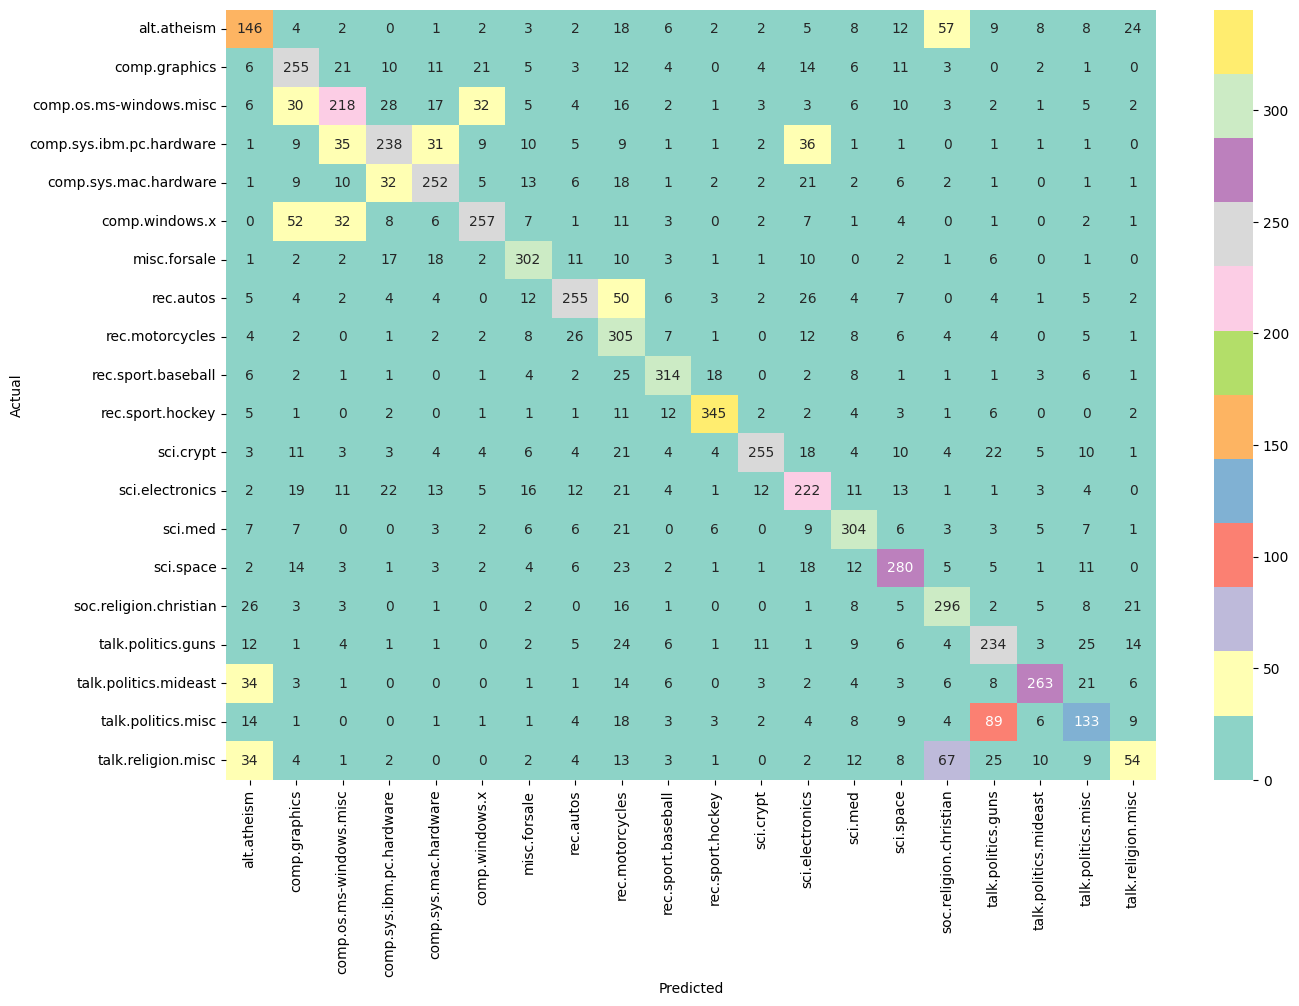

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       319
           1       0.59      0.66      0.62       389
           2       0.62      0.55      0.59       394
           3       0.64      0.61      0.62       392
           4       0.68      0.65      0.67       385
           5       0.74      0.65      0.69       395
           6       0.74      0.77      0.75       390
           7       0.71      0.64      0.68       396
           8       0.46      0.77      0.58       398
           9       0.81      0.79      0.80       397
          10       0.88      0.86      0.87       399
          11       0.84      0.64      0.73       396
          12       0.53      0.56      0.55       393
          13       0.72      0.77      0.75       396
          14       0.69      0.71      0.70       394
          15       0.64      0.74      0.69       398
          16       0.55      0.64      0.59       364
          17       0.83    

In [16]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # store predictions on test set in y_pred
# y_pred = LR_Classifier.predict(mydata_test_df.preproc)

# # calculate confusion matrix using built-in functionality in sklearn
# conf_mat = confusion_matrix(mydata_test_df.target, y_pred)

# # Plot confusion_matrix
# fig, ax = plt.subplots(figsize=(15, 10))

# # remember labels = list(category_counts.keys())
# sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d", xticklabels=labels, yticklabels=labels)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

# Transform the preprocessed test data using the same TF-IDF vectorizer
X_test_tfidf_preproc = vectorizer.transform(mydata_test_df['preproc'])

# Store predictions on test set in y_pred
y_pred = LR_Classifier.predict(X_test_tfidf_preproc)

precision = precision_score(mydata_test_df['target'], y_pred, average='weighted')
recall = recall_score(mydata_test_df['target'], y_pred, average='weighted')
f1 = f1_score(mydata_test_df['target'], y_pred, average='weighted')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# Calculate confusion matrix using built-in functionality in sklearn
conf_mat = confusion_matrix(mydata_test_df['target'], y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))

# Remember labels = list(category_counts.keys())
sns.heatmap(conf_mat, annot=True, cmap="Set3", fmt="d", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Print classification report for detailed precision, recall, and F1 scores per class
print(classification_report(mydata_test_df['target'], y_pred))